<a href="https://colab.research.google.com/github/reynancs/study-notes/blob/main/logreg_churn_reference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Aplicação de Regressão Logística para Classificação em Churn

**Objetivo:** criar um *notebook de referência* para regressão logística aplicada a problemas de **churn de clientes**, com explicações curtas sobre **o que é**, **como aplicar**, **o que avaliar** e **como interpretar**.  
Esse material serve como **apoio** para *case-studies* e *portfolio-projects*.

---



## 1) Introdução (O que é e por que usar)
A Regressão Logística é um modelo **linear** que estima a **probabilidade** de um evento (ex.: `churn=1`) a partir de um conjunto de variáveis explicativas.  
- **Saída:** probabilidade \(p(y=1 \mid x)\) via função sigmoide.  
- **Por que usar em churn:** baseline forte, **interpretável** e rápido de treinar; fornece **coeficientes** úteis para entender fatores de risco.

> **Resumo:** use como *baseline*, depois compare com árvores (Decision Tree, Random Forest, XGBoost).

---



## 2) Conceitos / Fundamentos (rápido)
- **Função sigmoide:** \\(\sigma(z) = \frac{1}{1 + e^{-z}}\\), com \\(z = \beta_0 + \beta^T x\\).  
- **Interpretação:** cada \\(\beta_j\\) indica impacto (log-odds). Exponenciando, obtemos **odds ratio**.  
- **Custo / Otimização:** normalmente maximização de verossimilhança (ou minimização de log-loss) com **regularização** (\\(L2\\) por padrão no scikit-learn).  
- **Assunções práticas:** relação aproximadamente **linear nos log-odds**; features escaladas ajudam estabilidade numérica; atenção a **multicolinearidade**.

---



## 3) Setup (bibliotecas e utilitários)


In [1]:

# Bibliotecas principais
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression

# Para tratamento de classes desbalanceadas (opcional)
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print(f"imblearn disponível? {IMBLEARN_AVAILABLE}")


imblearn disponível? True



## 4) Dados (carregamento e dicionário de variáveis)
> Substitua pelo seu dataset. Recomendação: `Telco Customer Churn` (Kaggle) ou o dataset da trilha IBM.  
**Como usar:** coloque o CSV em uma pasta `data/` na raiz do projeto e ajuste o caminho abaixo.


In [2]:

# === CONFIGURAÇÕES DO USUÁRIO ===
DATA_PATH = 'data/telco_churn.csv'  # ajuste para o seu arquivo
TARGET_COL = 'Churn'                # ajuste para o nome da sua coluna-alvo (0/1 ou Yes/No)

# === TENTATIVA DE CARREGAMENTO ===
try:
    df = pd.read_csv(DATA_PATH)
    print('Dataset carregado:', df.shape)
except FileNotFoundError:
    print('ATENÇÃO: Arquivo não encontrado. Coloque seu CSV em data/ e ajuste DATA_PATH.')
    # Cria um dataset sintético mínimo apenas para ilustrar o pipeline
    n = 600
    df = pd.DataFrame({
        'tenure': np.random.randint(0, 72, size=n),
        'MonthlyCharges': np.round(np.random.normal(80, 30, size=n), 2),
        'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], size=n, p=[0.6,0.25,0.15]),
        'SeniorCitizen': np.random.choice([0,1], size=n, p=[0.84, 0.16]),
        'TechSupport': np.random.choice(['No', 'Yes'], size=n, p=[0.7, 0.3]),
        'Churn': np.random.choice([0,1], size=n, p=[0.73, 0.27])
    })
    print('Dataset sintético criado:', df.shape)

df.head()


ATENÇÃO: Arquivo não encontrado. Coloque seu CSV em data/ e ajuste DATA_PATH.
Dataset sintético criado: (600, 6)


,tenure,MonthlyCharges,Contract,SeniorCitizen,TechSupport,Churn
0,51,70.61,One year,0,No,0
1,14,32.03,Month-to-month,0,Yes,0
2,71,38.94,One year,0,Yes,0
3,60,96.06,Month-to-month,0,No,0
4,20,111.81,Two year,1,Yes,0



### 4.1) Checagens rápidas (EDA leve)


In [3]:

display(df.head())
print('\nInfo:')
print(df.info())
print('\nDistribuição do alvo:')
print(df[TARGET_COL].value_counts(normalize=True).round(3))


,tenure,MonthlyCharges,Contract,SeniorCitizen,TechSupport,Churn
0,51,70.61,One year,0,No,0
1,14,32.03,Month-to-month,0,Yes,0
2,71,38.94,One year,0,Yes,0
3,60,96.06,Month-to-month,0,No,0
4,20,111.81,Two year,1,Yes,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          600 non-null    int64  
 1   MonthlyCharges  600 non-null    float64
 2   Contract        600 non-null    object 
 3   SeniorCitizen   600 non-null    int64  
 4   TechSupport     600 non-null    object 
 5   Churn           600 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 28.3+ KB
None

Distribuição do alvo:
Churn
0    0.735
1    0.265
Name: proportion, dtype: float64



## 5) Preparação dos Dados (pipeline)
- Identifique **features numéricas** e **categóricas**.  
- Faça **encoding** de categóricas (One-Hot).  
- **Escalonamento** ajuda a estabilidade da regressão logística.  
- Trate **desbalanceamento** de classes com `class_weight='balanced'` (baseline) ou **SMOTE** (opcional).


In [4]:

# Identificar tipos de colunas
target = TARGET_COL
y = df[target]

# Heurística simples para separar numéricas/categóricas
numerical_cols = df.drop(columns=[target]).select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.drop(columns=[target]).select_dtypes(exclude=[np.number]).columns.tolist()

print('Numéricas:', numerical_cols)
print('Categóricas:', categorical_cols)

X = df.drop(columns=[target]).copy()

# Pipeline de pré-processamento
from sklearn.preprocessing import OneHotEncoder
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Observação: escolha 1 — class_weight='balanced' (mais simples)
logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

pipeline = Pipeline(steps=[('preprocess', preprocess),
                          ('model', logreg)])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape


Numéricas: ['tenure', 'MonthlyCharges', 'SeniorCitizen']
Categóricas: ['Contract', 'TechSupport']


((450, 5), (150, 5))


> **Alternativa com SMOTE (opcional):** pode melhorar Recall para classe minoritária.  
Para usar, habilite o bloco abaixo **apenas se** `imblearn` estiver disponível.  


In [5]:

USE_SMOTE = False  # mude para True se quiser aplicar SMOTE

if USE_SMOTE and IMBLEARN_AVAILABLE:
    from imblearn.pipeline import Pipeline as ImbPipeline
    smote = SMOTE(random_state=RANDOM_STATE)
    pipeline = ImbPipeline(steps=[('preprocess', preprocess),
                                  ('smote', smote),
                                  ('model', logreg)])
    print('SMOTE habilitado.')
else:
    print('SMOTE não habilitado.')


SMOTE não habilitado.



## 6) Treinamento


In [6]:

pipeline.fit(X_train, y_train)
print('Treinamento concluído.')


Treinamento concluído.



## 7) Avaliação (métricas e curvas)
- Em churn, **Recall para a classe "churn=1"** geralmente é crítico (não perder quem está para sair).  
- Compare também **ROC-AUC** e **F1**.


In [7]:

def evaluate(model, X_tr, y_tr, X_te, y_te, positive_label=1):
    # Probabilidades (se disponível) e predições
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        # Se não houver probas, usamos decisão binária como aproximação
        y_proba = model.decision_function(X_te)
        # Normalização para [0,1] (fallback)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-9)

    y_pred = model.predict(X_te)

    metrics = {
        'accuracy': accuracy_score(y_te, y_pred),
        'precision': precision_score(y_te, y_pred, pos_label=positive_label, zero_division=0),
        'recall': recall_score(y_te, y_pred, pos_label=positive_label, zero_division=0),
        'f1': f1_score(y_te, y_pred, pos_label=positive_label, zero_division=0),
        'roc_auc': roc_auc_score(y_te, y_proba)
    }
    return metrics, y_pred, y_proba

metrics, y_pred, y_proba = evaluate(pipeline, X_train, y_train, X_test, y_test)
metrics


{'accuracy': 0.52,
 'precision': 0.28378378378378377,
 'recall': 0.525,
 'f1': 0.3684210526315789,
 'roc_auc': np.float64(0.5036363636363637)}

In [8]:

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Real:0','Real:1'], columns=['Pred:0','Pred:1'])
cm_df


,Pred:0,Pred:1
Real:0,57,53
Real:1,19,21


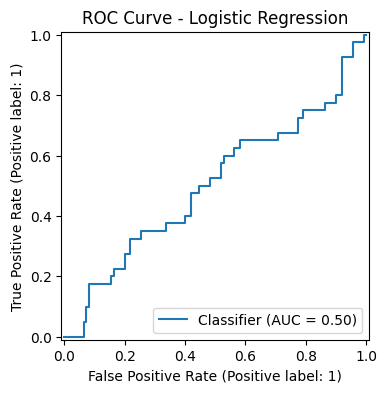

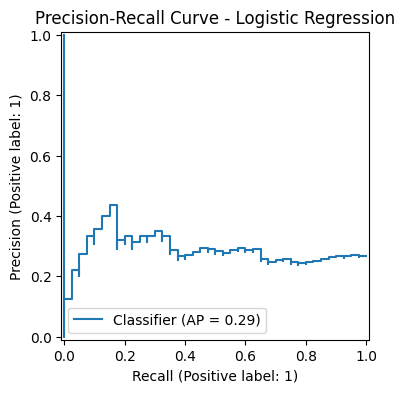

In [9]:

# Curva ROC e PR
fig, ax = plt.subplots(figsize=(6,4))
RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax)
plt.title('ROC Curve - Logistic Regression')
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=ax)
plt.title('Precision-Recall Curve - Logistic Regression')
plt.show()



## 8) Interpretação: Coeficientes e Odds Ratios
> Importante: após o `ColumnTransformer`, as features são expandidas (one-hot). Precisamos recuperar seus **nomes transformados** para interpretar os coeficientes.


In [10]:

# Recuperar nomes das features após o OneHotEncoder
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
num_features = numerical_cols
cat_features = list(ohe.get_feature_names_out(categorical_cols)) if len(categorical_cols) > 0 else []
all_features = num_features + cat_features

# Coeficientes do modelo
clf = pipeline.named_steps['model']
coefs = clf.coef_.ravel()

coef_df = pd.DataFrame({
    'feature': all_features,
    'coef': coefs,
    'odds_ratio': np.exp(coefs)
}).sort_values(by='odds_ratio', ascending=False)

coef_df.head(15)


,feature,coef,odds_ratio
4,Contract_One year,0.215523,1.240510
2,SeniorCitizen,0.095833,1.100575
7,TechSupport_Yes,0.063872,1.065955
5,Contract_Two year,-0.025979,0.974355
6,TechSupport_No,-0.035234,0.965380
1,MonthlyCharges,-0.077172,0.925731
0,tenure,-0.094283,0.910025
3,Contract_Month-to-month,-0.160905,0.851373



> **Leitura rápida:**  
- `odds_ratio > 1`: aumento nos *odds* de churn quando a feature cresce (ou quando a categoria está presente).  
- `odds_ratio < 1`: redução nos *odds* de churn.  
- **Atenção:** interpretação válida **mantendo as demais variáveis constantes**.



## 9) (Opcional) Ajuste de limiar de decisão
Em problemas desbalanceados, alterar o **threshold** pode melhorar Recall para a classe positiva (churn).


In [11]:

thresholds = np.linspace(0.1, 0.9, 9)
rows = []
for th in thresholds:
    y_hat = (y_proba >= th).astype(int)
    rows.append({
        'threshold': th,
        'precision': precision_score(y_test, y_hat, zero_division=0),
        'recall': recall_score(y_test, y_hat, zero_division=0),
        'f1': f1_score(y_test, y_hat, zero_division=0)
    })
pd.DataFrame(rows)


,threshold,precision,recall,f1
0,0.1,0.266667,1.000,0.421053
1,0.2,0.266667,1.000,0.421053
2,0.3,0.266667,1.000,0.421053
3,0.4,0.263514,0.975,0.414894
4,0.5,0.283784,0.525,0.368421
5,0.6,0.222222,0.050,0.081633
6,0.7,0.000000,0.000,0.000000
7,0.8,0.000000,0.000,0.000000
8,0.9,0.000000,0.000,0.000000



## 10) (Gancho) Comparação com outros modelos
Para transformar este *reference notebook* em **case-study**, adicione:
- Decision Tree (baseline interpretável)
- Random Forest e/ou XGBoost (modelos avançados)

No fim, crie uma **tabela comparativa** com as mesmas métricas.



## 11) Resumo (para colar no seu repositório de *study notes*)
- **O que é:** modelo linear probabilístico (log-odds).  
- **Como aplicar:** pipeline (preprocess → train → evaluate).  
- **O que avaliar:** Recall, F1, ROC-AUC, matriz de confusão.  
- **Destaques:** interpretável, rápido; ótimo como baseline em churn; atenção a escala e desbalanceamento.
